In [1]:
import dns
import numpy as np
from pathlib import Path
from scipy import optimize as opt
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
Ry = True
dt = 0.1
statesdir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8")
savedir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice")
states = sorted(list(statesdir.glob("state.*")))[6000:9000]
times = np.array([dt*i for i in range(len(states))])

In [3]:
state_, header_ = dns.readState(states[0])
forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt, itime, time = header_
ny_half = ny // 2

In [4]:
if Ry and ny_half % 2 != 0:
    exit("Ry but ny_half is not even.")

In [5]:
# projections_xu = np.zeros((len(states), ny_half-1), dtype=np.complex128)
# projections_zu = np.zeros((len(states), ny_half), dtype=np.complex128)

# projections_xv = np.zeros((len(states), ny_half-1), dtype=np.complex128)
# projections_zv = np.zeros((len(states), ny_half-1), dtype=np.complex128)

# projections_xw = np.zeros((len(states), ny_half), dtype=np.complex128)
# projections_zw = np.zeros((len(states), ny_half-1), dtype=np.complex128)

In [6]:
# times = []
# for istate in range(len(states)):
#     if istate % 100 == 0:
#         print(istate, len(states))
#     state, header = dns.readState(states[istate])
#     forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt_, itime, time = header
#     times.append(time)
#     if Ry:
#         # u component, only even modes
#         # x template
#         projections_xu[istate, :] = (state[1,1:,0,0] + np.conj(state[-1,1:,0,0]))/2
#         # z template
#         projections_zu[istate, :] = (state[0,:,1,0] + np.conj(state[0,:,-1,0]))/2
        
#         # v component, only odd modes
#         # x template
#         projections_xv[istate, :] = -1j*(state[1,1:,0,1] - np.conj(state[-1,1:,0,1]))/2
#         # z template
#         projections_zv[istate, :] = -1j*(state[0,1:,1,1] - np.conj(state[0,1:,-1,1]))/2
        
#         # w component, only even modes
#         # x template
#         projections_xw[istate, :] = (state[1,:,0,2] + np.conj(state[-1,:,0,2]))/2
#         # z template
#         projections_zw[istate, :] = (state[0,1:,1,2] + np.conj(state[0,1:,-1,2]))/2

In [7]:
# projections_x = np.zeros((len(states), 3*ny_half-2), dtype=np.complex128)
# projections_z = np.zeros((len(states), 3*ny_half-2), dtype=np.complex128)

# projections_x[:,:ny_half-1] = projections_xu[:,:]
# projections_x[:,ny_half-1:2*ny_half-2] = projections_xv[:,:]
# projections_x[:,2*ny_half-2:] = projections_xw[:,:]

# projections_z[:,:ny_half] = projections_zu[:,:]
# projections_z[:,ny_half:2*ny_half-1] = projections_zv[:,:]
# projections_z[:,2*ny_half-1:] = projections_zw[:,:]

In [8]:
def find_shift(projection):
    shift = (np.arctan2(projection.imag, projection.real) / (2 * np.pi)) % 1
    return shift

def find_dphases(projections):
    shifts = find_shift(projections)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt
    return dphases

def constraint_unit_template(coeffs):
    return np.sqrt(np.sum(coeffs**2))

def maximize_average(coeffs, projs):
    res = projs @ coeffs
    abs_res = np.abs(res)
    return -np.sqrt(np.average(abs_res**2))

In [14]:
def optimal_template(projections,str_projections,verbose=1,maxiter=1000):
    
    tag = f"{str_projections}"
    print(tag)
    
    nstates, ncoeffs = projections.shape
    x0 = np.ones((ncoeffs))/np.sqrt(ncoeffs)
    
    constraints = opt.NonlinearConstraint(constraint_unit_template,1,1)
    
    # run the optimization
    opts = opt.minimize(maximize_average,x0,args=(projections,),method="trust-constr",
                        constraints=constraints,
                        options={"verbose": verbose, "maxiter": maxiter})
    
    coeffs = opts.x
    
    # save coefficients
    np.savetxt(savedir / f"coeffs_{tag}.gp", coeffs)
    
    # save template
    template = np.zeros((nx, ny_half, nz, 3), dtype=np.complex128)
    if Ry:
        if str_projections == "x":
            template[1,1:,0,0] = coeffs[:ny_half-1] / 4
            template[-1,1:,0,0] = coeffs[:ny_half-1] / 4

            template[1,1:,0,1] = -1j*coeffs[ny_half-1:2*ny_half-2] / 4
            template[-1,1:,0,1] = -1j*coeffs[ny_half-1:2*ny_half-2] / 4

            template[1,:,0,2] = coeffs[2*ny_half-2:] / 4
            template[-1,:,0,2] = coeffs[2*ny_half-2:] / 4

        elif str_projections == "z":
            template[0,:,1,0] = coeffs[:ny_half] / 4
            template[0,:,-1,0] = coeffs[:ny_half] / 4

            template[0,1:,1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4
            template[0,1:,-1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4

            template[0,1:,1,2] = coeffs[2*ny_half-1:] / 4
            template[0,1:,-1,2] = coeffs[2*ny_half-1:]/ 4
    else:
        exit("Not yet implemented.")
    
            
    dns.writeState_nocompact(template,forcing=forcing,Lx=Lx,Lz=Lz,Re=Re,tilt_angle=tilt_angle,dt=dt,
                   outFile = savedir / f"u_{str_projections}p.000000")

    projections_opt = np.einsum("ij,j",projections,coeffs,dtype=np.complex128)
    abs_projections_opt = np.abs(projections_opt)
    shifts = find_shift(projections_opt)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt

    fig, ax = plt.subplots()
    ax.plot(times, np.abs(projections_opt))
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$|p_{str_projections}|$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"p{tag}.png", bbox_inches="tight")

    # Plot phases
    fig, ax = plt.subplots()
    ax.plot(times, phases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\phi_{str_projections}$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"phase_{tag}.png", bbox_inches="tight")

    # Plot phase derivatives
    fig, ax = plt.subplots()
    ax.plot(times[:-1], dphases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\dot{{\\phi_{str_projections}}}$")
    ax.set_xlim(left=times[0], right=times[-2])
#     ax.set_xlim(600,900)
    fig.savefig(savedir / f"dphase_{tag}.png", bbox_inches="tight")
    
    plt.show()

In [10]:
# optimal_template(np.conj(projections_x),"x")
# optimal_template(np.conj(projections_z),"z")

In [11]:
# read projections from runtime
projdir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice_runtime")
p_uw = np.loadtxt(projdir / "slice_projections_uw.gp")[:len(states),2:]
p_v = np.loadtxt(projdir / "slice_projections_v.gp")[:len(states),2:]

ny_half = p_uw.shape[-1] // 8
n_states = p_uw.shape[0]

projections_xu_runtime = p_uw[:,:ny_half] + 1j*p_uw[:,ny_half:2*ny_half]
projections_zu_runtime = p_uw[:,4*ny_half:5*ny_half] + 1j*p_uw[:,5*ny_half:6*ny_half]

projections_xv_runtime = p_v[:,:ny_half-1] + 1j*p_v[:,ny_half-1:2*ny_half-2]
projections_zv_runtime = p_v[:,2*ny_half-2:3*ny_half-3] + 1j*p_v[:,3*ny_half-3:]

projections_xw_runtime = p_uw[:,2*ny_half:3*ny_half] + 1j*p_uw[:,3*ny_half:4*ny_half]
projections_zw_runtime = p_uw[:,6*ny_half:7*ny_half] + 1j*p_uw[:,7*ny_half:8*ny_half]

In [12]:
projections_x_runtime = np.zeros((len(states), 3*ny_half-2), dtype=np.complex128)
projections_z_runtime = np.zeros((len(states), 3*ny_half-2), dtype=np.complex128)

projections_x_runtime[:,:ny_half-1] = projections_xu_runtime[:,1:]
projections_x_runtime[:,ny_half-1:2*ny_half-2] = projections_xv_runtime[:,:]
projections_x_runtime[:,2*ny_half-2:] = projections_xw_runtime[:,:]

projections_z_runtime[:,:ny_half] = projections_zu_runtime[:,:]
projections_z_runtime[:,ny_half:2*ny_half-1] = projections_zv_runtime[:,:]
projections_z_runtime[:,2*ny_half-1:] = projections_zw_runtime[:,1:]

x


/home/gokhan/usr/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 102, function evaluations: 4554, CG iterations: 292, optimality: 9.21e-09, constraint violation: 0.00e+00, execution time: 0.51 s.


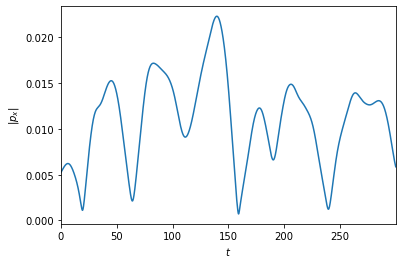

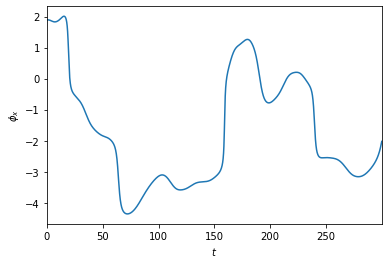

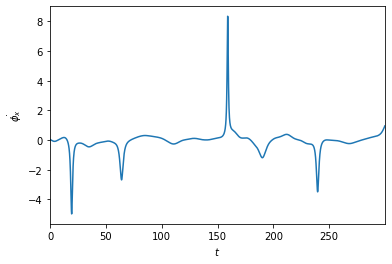

z
`gtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 1449, CG iterations: 97, optimality: 8.47e-09, constraint violation: 0.00e+00, execution time: 0.16 s.


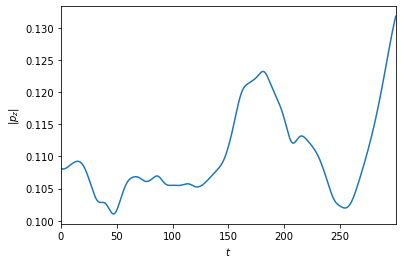

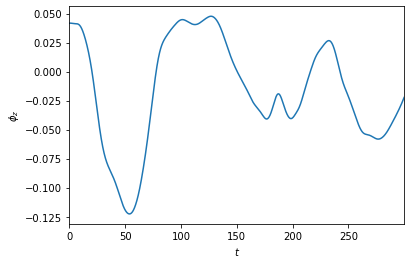

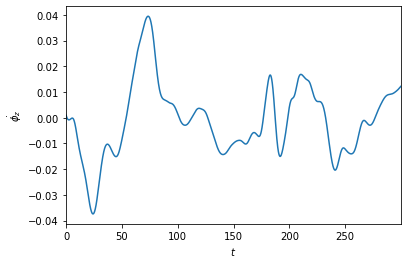

In [15]:
optimal_template(np.conj(projections_x_runtime),"x")
optimal_template(np.conj(projections_z_runtime),"z")

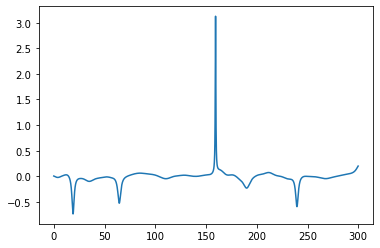

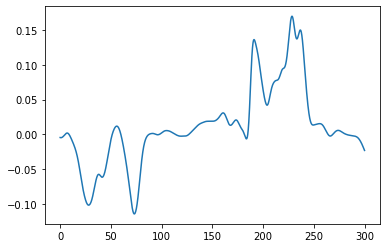

In [20]:
phases = np.loadtxt("/home/gokhan/projects/dnsbox/re180Lx24Lz8/slice/phases.gp")
times_sim = phases[:,1]
dt_sim = times_sim[1:] - times_sim[:-1]
dphix = (np.unwrap(phases[1:,2] - phases[:-1,2]))/dt_sim
dphiz = (np.unwrap(phases[1:,3] - phases[:-1,3]))/dt_sim

fig, ax = plt.subplots()
ax.plot(times_sim[:-1], dphix)

fig, ax = plt.subplots()
ax.plot(times_sim[:-1], dphiz)